In [23]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors, latex_fix
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.optimize import minimize
from scipy.integrate import quad
from matplotlib import pyplot as plt

In [24]:
mp_key = "ER5V8i0JUw7k31Nk5IpkvogP61BDz9cw"
mp_id = "mp-569677"

In [25]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Phonon bandstructure

In [26]:
fig_ph_bs = get_plot_bs(ph_bs)
fig_ph_bs.update_yaxes(rangemode="tozero")
fig_ph_bs.show()

In [27]:
fig_ph_dos = get_plot_dos(ph_dos)
fig_ph_dos.show()

In [28]:
fig_ph_bs_and_dos = get_plot_bs_and_dos(ph_bs, ph_dos)
fig_ph_bs_and_dos.update_yaxes(rangemode="tozero")
fig_ph_bs_and_dos.show()

**Données**

In [29]:
nat = len(prim_struc)
R = 8.314   
k_B = 1.380649e-23  # J/K
hbar = 1.054e-34  # J.s
toTHz = 1e-12    

temperatures = np.arange(0, 1000, 5)  # Inclut 0
cv_ph = np.array([ph_dos.cv(T) for T in temperatures]) / (3 * nat * R)

# Modèle d'Einstein

In [30]:
def Einstein(T, theta_E):
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore les erreurs de division
        result = np.where(
            T == 0, 
            0, 
            (theta_E / T) ** 2 * (np.exp(theta_E / T) / (np.exp(theta_E / T) - 1) ** 2)
        )
    return result

def error_Einstein(theta_E):
    Cv_E = Einstein(temperatures, theta_E)
    return np.sum((cv_ph - Cv_E) ** 2)

theta_E_init = 300
theta_E_optimal = minimize(error_Einstein, theta_E_init).x[0]

print("La température d'Einstein qui minimise l'erreur au sens des moindres carrés est de", theta_E_optimal, "K")

La température d'Einstein qui minimise l'erreur au sens des moindres carrés est de 200.4818839599222 K


# Modèle de Debye

In [31]:
def integrand(x):
    exp = np.exp(x)
    return (x**4 * exp) / ((exp-1)**2)

def Debye(T, theta_D):
    if T == 0 or theta_D == 0:
        return 0
    integral, _ = quad(integrand, 0, theta_D / T)  # Limite pour éviter instabilités
    return 3 * ((T / theta_D) ** 3) * integral

def error_Debye(theta_D):
    theta_D = np.atleast_1d(theta_D)[0]  # Assurer un scalaire
    Cv_D = np.array([Debye(T, theta_D) for T in temperatures])
    return np.sum((cv_ph - Cv_D) ** 2)

theta_D_init = 270
theta_D_optimal = minimize(error_Debye, theta_D_init).x[0]

print("La température de Debye qui minimise l'erreur au sens des moindres carrés est de", theta_D_optimal, "K")

La température de Debye qui minimise l'erreur au sens des moindres carrés est de 272.4998215738561 K


# Courbe de chaleur spécifique

In [32]:
Cv_E = Einstein(temperatures, theta_E_optimal)
Cv_D = np.array([Debye(T, theta_D_optimal) for T in temperatures])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=temperatures, y=cv_ph,
    mode='lines', line=dict(color='blue', width=2),
    name="Cv phonon"
))

fig.add_trace(go.Scatter(
    x=temperatures, y=Cv_E,
    mode='lines', line=dict(color='green', width=2, dash='dash'),
    name="Modèle Einstein"
))

fig.add_trace(go.Scatter(
    x=temperatures, y=Cv_D,
    mode='lines', line=dict(color='purple', width=2, dash='dot'),
    name="Modèle Debye"
))

fig.add_hline(y=1, line_width=2, line_color="red", line_dash="dash", annotation_text="Limite classique")

fig.update_layout(
    xaxis={'mirror': True, 'showgrid': False, 'ticks': 'inside', 'ticklen': 10},
    yaxis={'mirror': True, 'showgrid': False, 'ticks': 'inside', 'ticklen': 10},
    xaxis_title="Température (K)",
    yaxis_title="C<sub>v</sub> / 3N_{\!at}R",
    legend=dict(title="Légende"),
    title="Comparaison des modèles d'Einstein et Debye",
)

# Ajout du zoom en inset
fig.add_trace(go.Scatter(
    x=temperatures[temperatures < 200], y=cv_ph[temperatures < 200],
    mode='lines', line=dict(color='blue', width=2),
    showlegend=False,
    xaxis='x2', yaxis='y2'
))

fig.add_trace(go.Scatter(
    x=temperatures[temperatures < 200], y=Cv_E[temperatures < 200],
    mode='lines', line=dict(color='green', width=2, dash='dash'),
    showlegend=False,
    xaxis='x2', yaxis='y2'
))

fig.add_trace(go.Scatter(
    x=temperatures[temperatures < 200], y=Cv_D[temperatures < 200],
    mode='lines', line=dict(color='purple', width=2, dash='dot'),
    showlegend=False,
    xaxis='x2', yaxis='y2'
))

fig.update_layout(
    xaxis2=dict(domain=[0.65, 0.95], anchor='y2', title="T (K)", range=[0, 200]),
    yaxis2=dict(domain=[0.15, 0.5], anchor='x2', title="C<sub>v</sub>", range=[0, 1]),
)

fig.show()


# Densités d'états de phonons correspondantes

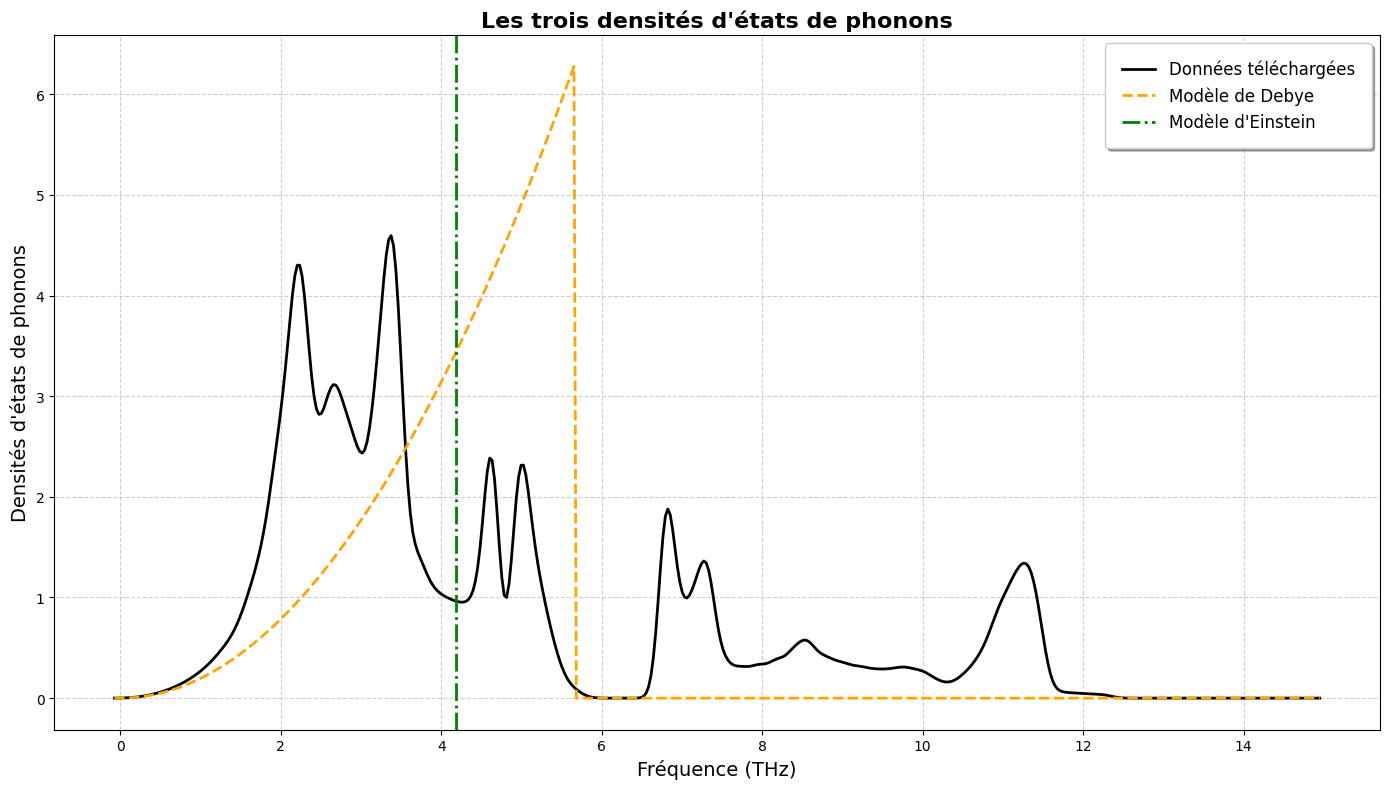

In [35]:
freq = ph_dos.frequencies 
dens = ph_dos.densities

omega_E = toTHz * (theta_E_optimal * k_B) / hbar   
omega_D = toTHz * (theta_D_optimal * k_B) / hbar

dens_D = np.zeros(len(freq))
for i, f in enumerate(freq):
    omega = 2 * np.pi * f
    if omega < omega_D:
        dens_D[i] = (9 * nat * (omega) ** 2 / (omega_D ** 3))

plt.figure(figsize=(14, 8))
plt.plot(freq, dens, color='black', linewidth=2, linestyle='-', label="Données téléchargées")
plt.plot(freq, dens_D * 2 * np.pi, color='orange', linewidth=2, linestyle='--', label="Modèle de Debye")
plt.axvline(omega_E / (2 * np.pi), color='green', linewidth=2, linestyle='-.', label="Modèle d'Einstein")

plt.ylabel("Densités d'états de phonons", fontsize=14)
plt.xlabel("Fréquence (THz)", fontsize=14)
plt.title("Les trois densités d'états de phonons", fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, borderpad=1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()